In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
# %tensorflow_version 1.x
import random

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121

from imgaug import augmenters
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = scale)
  return augment(data, fun)

def flip_left_right(data, prob):
  fun = augmenters.Fliplr(p = prob)
  return augment(data, fun)

def flip_up_down(data, prob):
  fun = augmenters.Flipud(p = prob)
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    field_data, field_labels = get_data_split('field', flatten, all_data, metadata, image_shape)
    field_data[:,:,:,2] = field_data[:,:,:,0]
    field_data[:,:,:,1] = field_data[:,:,:,0]

    #make data messier
    rand = random.uniform(-1, 1)

    for i in range(len(field_data)):
      image = field_data[i]

      if abs(rand) < 0.5:
        image = rotate(image, rotate = rand * 40)
      elif abs(rand) < 0.8:
        image = shear(image, shear = rand*40)
      field_data[i] = image
    return field_data, field_labels

class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 4)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    model.add(Dropout(0.5))

    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      model.add(Dropout(0.5))

    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(64, (3, 3), padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 64, activation = 'relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.legacy.RMSprop(learning_rate=1e-5, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.5))

    expert_model.add(Dense(64, activation = 'relu'))
    expert_model.add(Dropout(0.5))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    return expert_model

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy"


### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

metadata.csv        100%[===================>]  39.56K  --.-KB/s    in 0.002s  
image_data.npy      100%[===================>] 131.25M  23.9MB/s    in 6.3s    


Previously we worked with CNNs, which we saw perform much better than multi-layer perceptrons on imaging data.

Let's **re-train a 2-layer CNN and plot its accuracy over time.**

Epoch 1/50
63/63 [==============================] - 11s 23ms/step - loss: 1.9897 - accuracy: 0.5225 - val_loss: 1.9729 - val_accuracy: 0.7075
Epoch 2/50
63/63 [==============================] - 1s 10ms/step - loss: 1.9620 - accuracy: 0.5645 - val_loss: 1.9476 - val_accuracy: 0.7750
Epoch 3/50
63/63 [==============================] - 1s 16ms/step - loss: 1.9372 - accuracy: 0.6260 - val_loss: 1.9195 - val_accuracy: 0.6825
Epoch 4/50
63/63 [==============================] - 1s 9ms/step - loss: 1.9085 - accuracy: 0.6645 - val_loss: 1.8912 - val_accuracy: 0.8075
Epoch 5/50
63/63 [==============================] - 1s 8ms/step - loss: 1.8773 - accuracy: 0.7145 - val_loss: 1.8628 - val_accuracy: 0.8000
Epoch 6/50
63/63 [==============================] - 0s 8ms/step - loss: 1.8514 - accuracy: 0.7080 - val_loss: 1.8387 - val_accuracy: 0.7975
Epoch 7/50
63/63 [==============================] - 1s 8ms/step - loss: 1.8221 - accuracy: 0.7310 - val_loss: 1.8135 - val_accuracy: 0.7975
Epoch 8/50
63/63

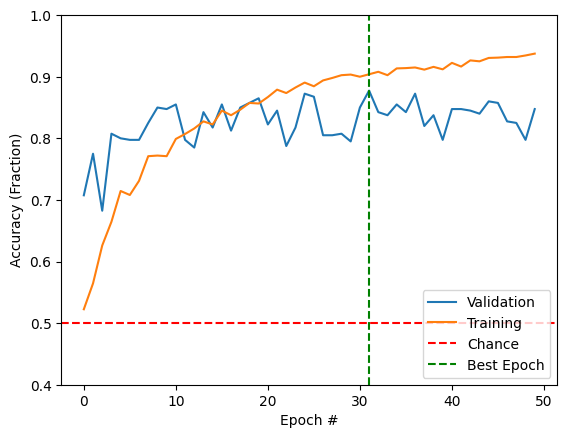

In [ ]:
train_data, train_labels = get_train_data()
test_data, test_labels   = get_test_data()

cnn = CNNClassifier(2)
cnn_history = cnn.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
plot_acc(cnn_history)

In [ ]:
train_data, train_labels = get_train_data()
test_data, test_labels   = get_test_data()
field_data, field_labels = get_field_data()

average_accuracy = 0.0
for i in range(5):
  cnn_temp = CNNClassifier(5)
  cnn_temp.fit(train_data, train_labels, epochs = 5, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

  predictions = (cnn_temp.predict(field_data) > 0.5)
  accuracy = accuracy_score(field_labels, predictions)
  print('Accuracy on this run: %0.2f' % accuracy)

  average_accuracy += accuracy / 5.0
print('Average accuracy: ', average_accuracy)

Epoch 1/5
63/63 [==============================] - 3s 14ms/step - loss: 3.9194 - accuracy: 0.4930 - val_loss: 3.8881 - val_accuracy: 0.5000
Epoch 2/5
63/63 [==============================] - 1s 8ms/step - loss: 3.8603 - accuracy: 0.5055 - val_loss: 3.8301 - val_accuracy: 0.5000
Epoch 3/5
63/63 [==============================] - 1s 8ms/step - loss: 3.8027 - accuracy: 0.5230 - val_loss: 3.7727 - val_accuracy: 0.5000
Epoch 4/5
63/63 [==============================] - 1s 8ms/step - loss: 3.7473 - accuracy: 0.5090 - val_loss: 3.7164 - val_accuracy: 0.5000
Epoch 5/5
13/13 [==============================] - 0s 3ms/step
Accuracy on this run: 0.50
Epoch 1/5
63/63 [==============================] - 2s 14ms/step - loss: 3.9150 - accuracy: 0.5085 - val_loss: 3.8817 - val_accuracy: 0.5000
Epoch 2/5
63/63 [==============================] - 1s 8ms/step - loss: 3.8522 - accuracy: 0.5040 - val_loss: 3.8199 - val_accuracy: 0.6150
Epoch 3/5
63/63 [==============================] - 1s 8ms/step - loss: 3.7

FIELD data:
Label: 1.0


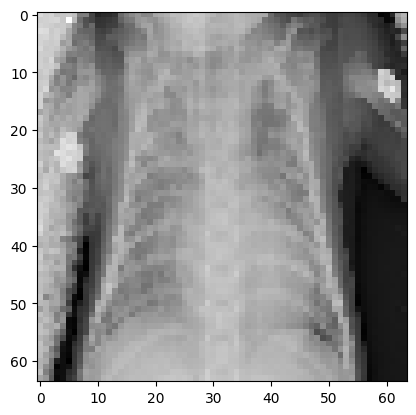

Label: 1.0


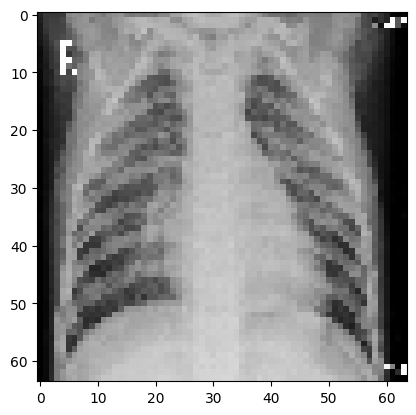

Label: 0.0


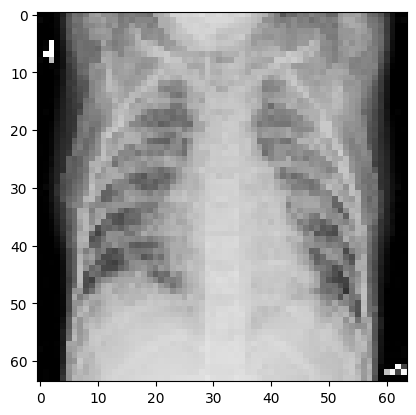

Label: 0.0


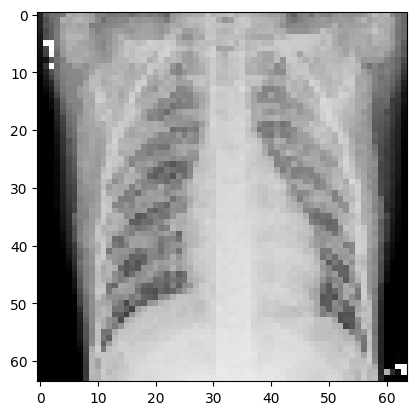

Label: 0.0


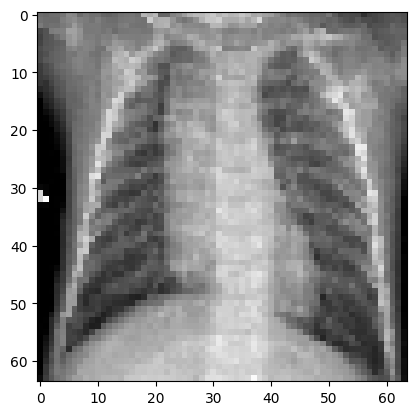

Label: 1.0


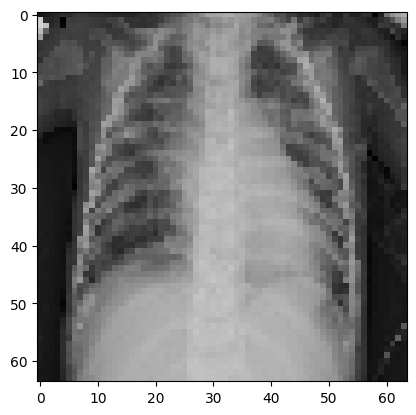

Label: 0.0


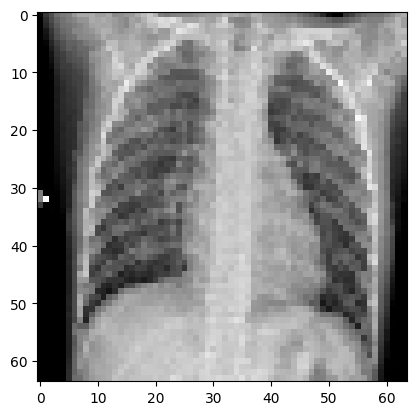

Label: 1.0


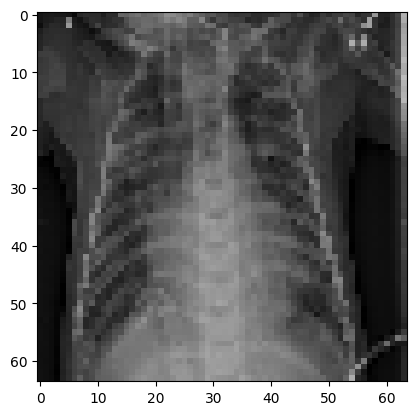

Label: 0.0


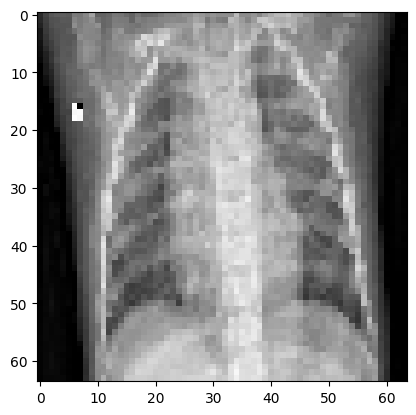

Label: 0.0


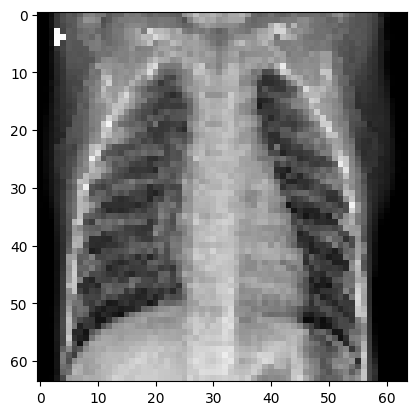

TRAIN data:
Label: 0.0


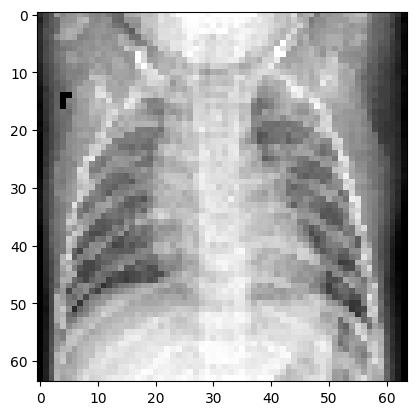

Label: 0.0


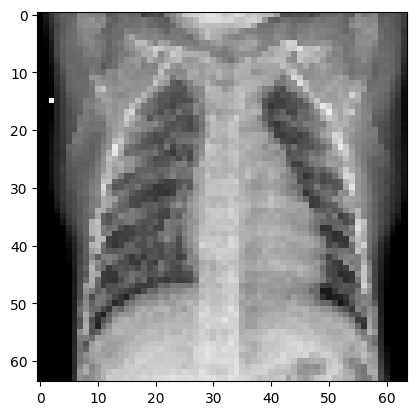

Label: 1.0


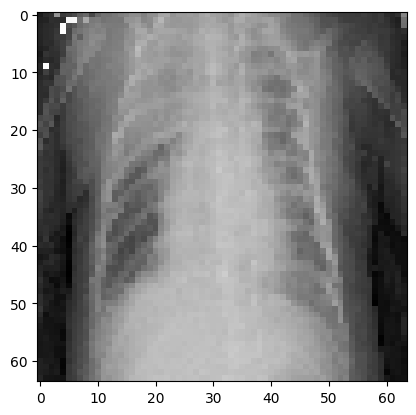

Label: 0.0


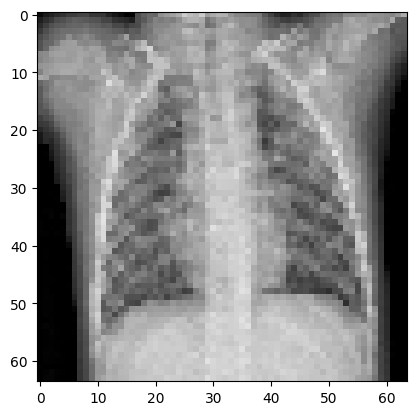

Label: 1.0


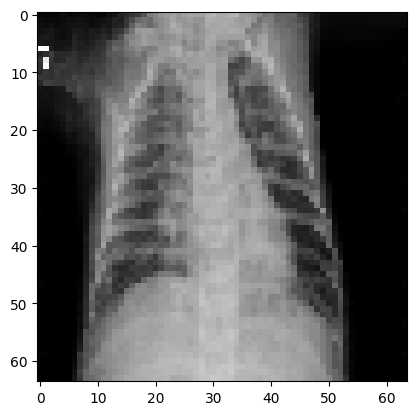

Label: 1.0


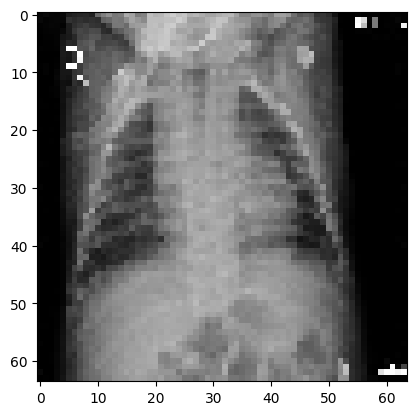

Label: 1.0


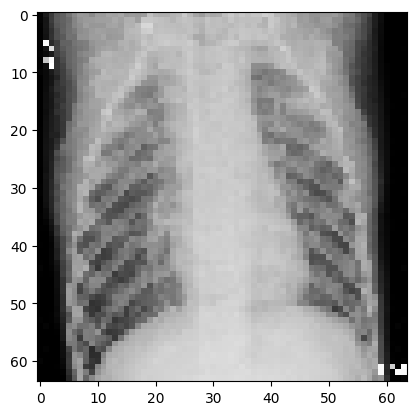

Label: 0.0


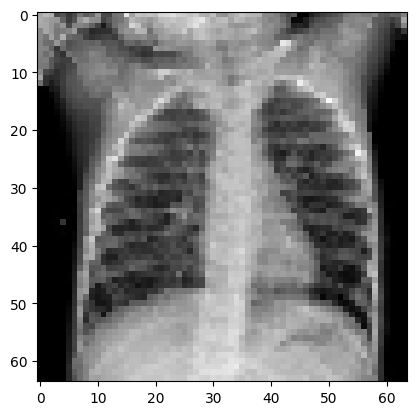

Label: 1.0


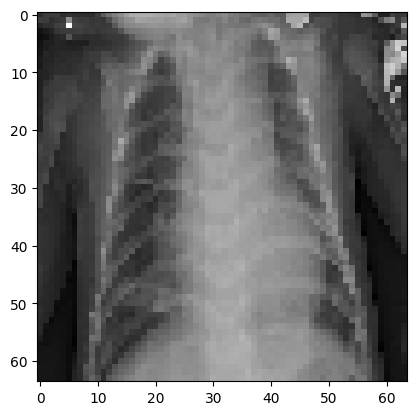

Label: 1.0


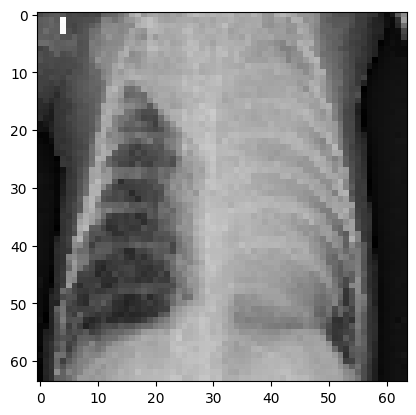

TEST data:
Label: 1.0


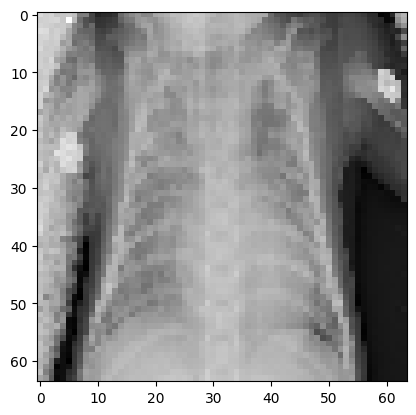

Label: 1.0


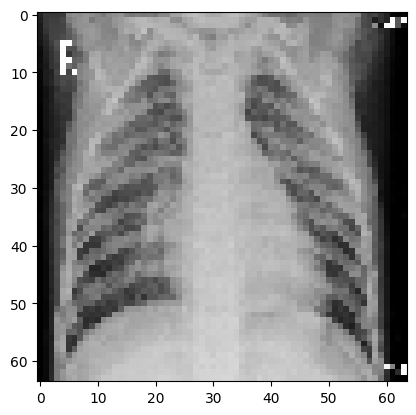

Label: 0.0


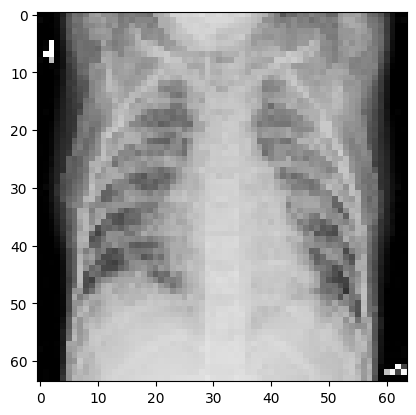

Label: 0.0


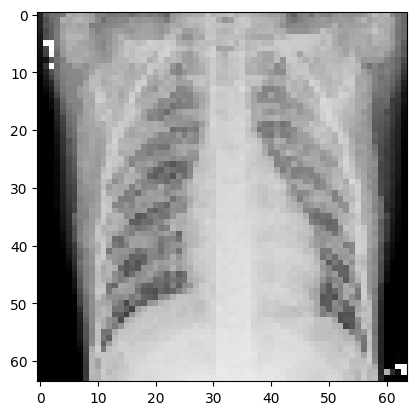

Label: 0.0


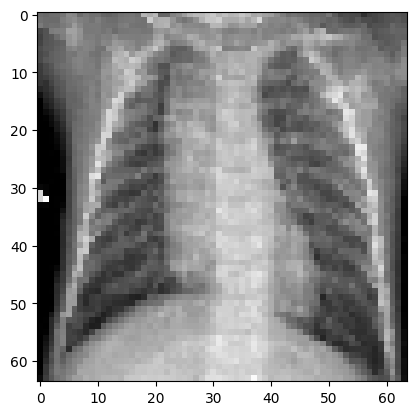

Label: 1.0


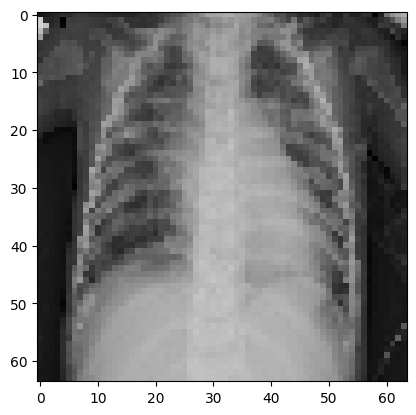

Label: 0.0


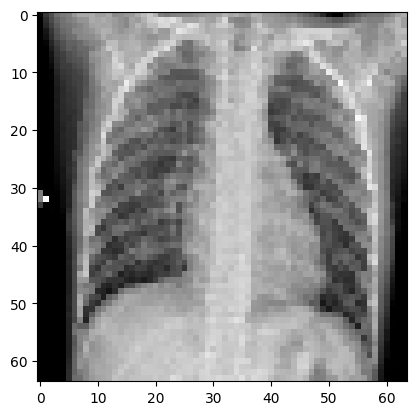

Label: 1.0


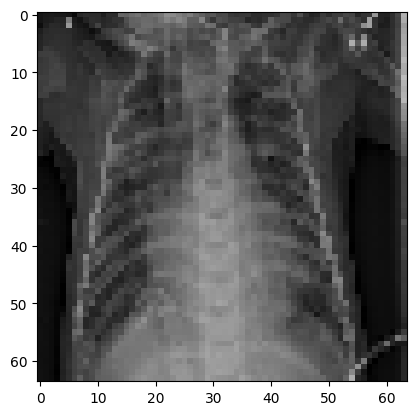

Label: 0.0


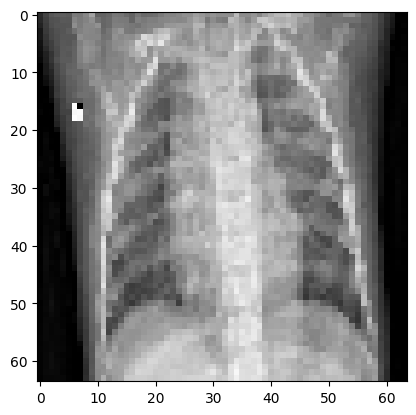

Label: 0.0


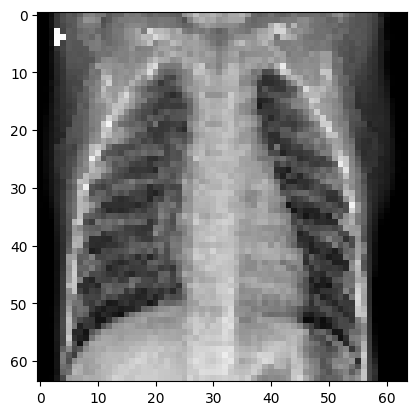

In [ ]:
print ("FIELD data:")
for i in range(10):
  plot_one_image(field_data, field_labels, i)

print ("TRAIN data:")
for i in range(10):
  plot_one_image(train_data, train_labels, i)

print ("TEST data:")
for i in range(10):
  plot_one_image(test_data, test_labels, i)

So, how do we augment our images in Python?


We provide custom functions for augmenting a single image. Here's one example, to rotate a single image by 40 degrees.

Label: 


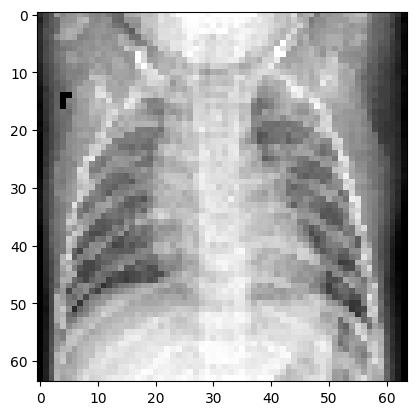

Label: 


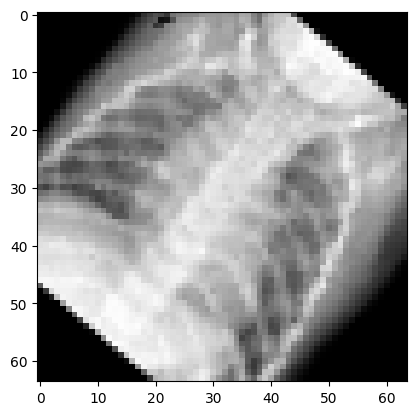

In [ ]:
image = train_data[0]
plot_one_image(image)
new_image = rotate(image, rotate = 40)
plot_one_image(new_image)

Now, let's create some augmented datasets of our own! We'll combine the augmented data with the original. Here's how you make an augmented dataset:

In [ ]:
train_data_rotated_10 = rotate(train_data, rotate=10)
train_data_rotated_180 = rotate(train_data, rotate=180)
train_data_rotated_270 = rotate(train_data, rotate=270)
red_train  = remove_color(remove_color(train_data, channel = 1), channel = 2)

In [ ]:
# combining all the datasets
all_data, all_labels = combine_data([train_data, train_data_rotated_10, train_data_rotated_180, train_data_rotated_270, red_train], \
                                    [train_labels, train_labels, train_labels, train_labels, train_labels,])

In [ ]:
train_data, train_labels   = get_train_data()
test_data, test_labels     = get_test_data()
field_data, field_labels   = get_field_data()

average_accuracy = 0.0

for i in range(5):
  cnn = CNNClassifier(2)
  cnn.fit(all_data, all_labels, epochs = 20, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
  predictions = (cnn.predict(field_data) > 0.5)
  accuracy = accuracy_score(field_labels, predictions)
  print('Accuracy:%0.2f'%accuracy)
  average_accuracy += accuracy

average_accuracy /= 5.0

print('Average accuracy: ', average_accuracy)

Epoch 1/20
313/313 [==============================] - 3s 8ms/step - loss: 1.9858 - accuracy: 0.5639 - val_loss: 1.9214 - val_accuracy: 0.6050
Epoch 2/20
313/313 [==============================] - 2s 7ms/step - loss: 1.8756 - accuracy: 0.6728 - val_loss: 1.8032 - val_accuracy: 0.7275
Epoch 3/20
313/313 [==============================] - 2s 7ms/step - loss: 1.7655 - accuracy: 0.7421 - val_loss: 1.6881 - val_accuracy: 0.8650
Epoch 4/20
313/313 [==============================] - 3s 8ms/step - loss: 1.6622 - accuracy: 0.7891 - val_loss: 1.5938 - val_accuracy: 0.8300
Epoch 5/20
313/313 [==============================] - 2s 7ms/step - loss: 1.5650 - accuracy: 0.8226 - val_loss: 1.4804 - val_accuracy: 0.8625
Epoch 6/20
313/313 [==============================] - 2s 7ms/step - loss: 1.4726 - accuracy: 0.8356 - val_loss: 1.3944 - val_accuracy: 0.8625
Epoch 7/20
313/313 [==============================] - 2s 7ms/step - loss: 1.3900 - accuracy: 0.8540 - val_loss: 1.3174 - val_accuracy: 0.8625
Epoch 